In [1]:
import abagen
import pandas as pd
import os
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# fetch Allen human brain atlas
if not os.path.exists('raw_data/Allen_exp_DK_atlas.csv'):
    atlas = abagen.fetch_desikan_killiany()
    DK_allen_exp = abagen.get_expression_data(atlas['image'], atlas['info'],missing='centroids',lr_mirror='leftright',\
                                             norm_structures='cortex').T
    DK_allen_exp = DK_allen_exp.iloc[:,:-1]
    DK_regions = pd.read_csv('raw_data/atlas/DK_atlas_regions.csv')['regions'].values.tolist()
    DK_allen_exp.columns = DK_regions
    DK_allen_exp.to_csv('raw_data/Allen_exp_DK_atlas.csv')
else:
    DK_allen_exp = pd.read_csv('raw_data/Allen_exp_DK_atlas.csv').set_index('gene_symbol')

In [3]:
# load association results
CT_corr = pd.read_csv('results/imaging_associations/CT_corr_PC1.csv')
funcPC1 = pd.read_csv('results/imaging_associations/func_PCs.csv')

y1 = CT_corr.iloc[:,0].values
y2 = funcPC1.iloc[:,0].values

In [4]:
regions = CT_corr['regions'].values.tolist()
DK_allen_exp = DK_allen_exp[regions]

In [5]:
# load GWAS for PC1 of four risky behaviors
sig_MAGMA_data = pd.read_csv('raw_data/GWAS_sig_genes.txt',sep='\t')
sig_genes = list(set(sig_MAGMA_data['symbol'].values.tolist()))

In [6]:
numbers = sig_MAGMA_data['symbol'].values.tolist()
duplicates = [number for number in numbers if numbers.count(number) > 1]

In [7]:
allen_genes = DK_allen_exp.index.tolist()
com_genes = list(set(allen_genes) & set(sig_genes))
added_col = []
for number in numbers:
    if number in com_genes:
        added_col.append(1)
    else:
        added_col.append(0)
sig_MAGMA_data['overlapping status with AHBA'] = added_col
sig_MAGMA_data.to_csv('raw_data/GWAS_sig_genes2.csv',index=False)

In [8]:
# FDR multiple comparison correction
from statsmodels.stats import multitest
def fdr_correction(data):
    Ps = multitest.multipletests(data,alpha=0.05,method='fdr_bh')
    return Ps[1]

/data/sliu/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
# association analysis based on genes related to risky behaviors
re_com_genes_CT = np.zeros((len(com_genes),2))
re_com_genes_funcPC1 = np.zeros((len(com_genes),2))
for i in range(len(com_genes)):
    gene = com_genes[i]
    x = DK_allen_exp.loc[gene].values
    re_com_genes_CT[i,0],re_com_genes_CT[i,1] = stats.spearmanr(x,y1)
    re_com_genes_funcPC1[i,0],re_com_genes_funcPC1[i,1] = stats.spearmanr(x,y2)

In [10]:
df_com_genes_CT = pd.DataFrame(data=re_com_genes_CT,columns=['r','p'])
df_com_genes_CT['fdr_p'] = fdr_correction(df_com_genes_CT['p'].values)
df_com_genes_CT['genes'] = com_genes
df_com_genes_CT.sort_values(by=['p'],inplace=True)
df_com_genes_CT.to_csv('results/expression_associations/sig_genes_CT.csv',index=False)

df_com_genes_funcPC1 = pd.DataFrame(data=re_com_genes_funcPC1,columns=['r','p'])
df_com_genes_funcPC1['fdr_p'] = fdr_correction(df_com_genes_funcPC1['p'].values)
df_com_genes_funcPC1['genes'] = com_genes
df_com_genes_funcPC1.sort_values(by=['p'],inplace=True)
df_com_genes_funcPC1.to_csv('results/expression_associations/sig_genes_funcPC1.csv',index=False)

In [11]:
# global analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = DK_allen_exp.values.T
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=10)
pca_exp = pca.fit(X)
X_c = stats.zscore(pca_exp.transform(X),axis=0)
print("explained variance ratio of PCs for allen genes:",np.round(pca_exp.explained_variance_ratio_,4))

cols = []
for i in range(10):
    cols.append('PC'+str(i+1))
df_PCs = pd.DataFrame(data=X_c,columns=cols)
df_PCs['regions'] = regions
df_PCs.to_csv('results/expression_associations/gene_PCs.csv',index=False)

r1,p1 = stats.spearmanr(X_c[:,0],y1)
print("PC1 vs CT",r1,p1)
r2,p2 = stats.spearmanr(X_c[:,0],y2)
print("PC1 vs funcPC1",r2,p2)

r1,p1 = stats.spearmanr(X_c[:,1],y1)
print("PC2 vs CT",r1,p1)
r2,p2 = stats.spearmanr(X_c[:,1],y2)
print("PC2 vs funcPC1",r2,p2)

explained variance ratio of PCs for allen genes: [0.3034 0.1884 0.0979 0.0805 0.0575 0.0465 0.0332 0.0306 0.0218 0.0157]
PC1 vs CT 0.15793923327478882 0.20531435827267436
PC1 vs funcPC1 0.19824859878544399 0.1105582701427999
PC2 vs CT 0.1672494233409474 0.17951302993918686
PC2 vs funcPC1 -0.37910843451010307 0.0016945649160152022


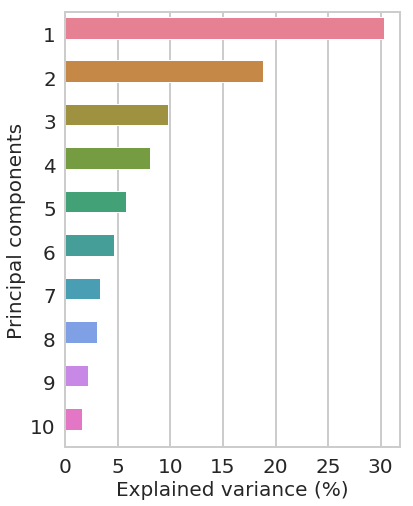

In [12]:
# plot the explained variance of PCs of allen gene expression matrix
tmpdata = pd.DataFrame(data=np.round(pca_exp.explained_variance_ratio_,4)*100,columns=['variance'])
PCs = []
for i in range(10):
    PCs.append('PC'+str(i+1))
tmpdata['PCs'] = PCs

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6,8))

sns.barplot(x="variance", y="PCs", data=tmpdata, palette = "husl")
for patch in ax.patches :
    patch.set_height(0.5)

ax.set_yticklabels(np.arange(10)+1, size = 20)
ax.set_xticklabels([0,5,10,15,20,25,30], size = 20)
plt.xlabel('Explained variance (%)',fontsize=20)
plt.ylabel('Principal components',fontsize=20)
ax.xaxis.grid(True,linewidth=2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
plt.savefig('results/statistical_figures/all_genes_explained_variance.png', dpi=300,bbox_inches = 'tight')

In [13]:
# calculate the transcriptional relationships for all genes
all_genes_corrs_CT = np.zeros((X.shape[1],2))
all_genes_corrs_funcPC1 = np.zeros((X.shape[1],2))
for j in range(X.shape[1]):
    x = X[:,j]
    all_genes_corrs_CT[j,0],all_genes_corrs_CT[j,1] = stats.spearmanr(x,y1)
    all_genes_corrs_funcPC1[j,0],all_genes_corrs_funcPC1[j,1] = stats.spearmanr(x,y2)
    
df_all_genes_CT = pd.DataFrame(data=all_genes_corrs_CT,columns=['r','p'])
df_all_genes_CT['fdr_p'] = fdr_correction(df_all_genes_CT['p'].values)
df_all_genes_CT['genes'] = allen_genes
df_all_genes_CT.sort_values(by=['p'],inplace=True)
df_all_genes_CT.to_csv('results/expression_associations/all_genes_CT.csv',index=False)

df_all_genes_funcPC1 = pd.DataFrame(data=all_genes_corrs_funcPC1,columns=['r','p'])
df_all_genes_funcPC1['fdr_p'] = fdr_correction(df_all_genes_funcPC1['p'].values)
df_all_genes_funcPC1['genes'] = allen_genes
df_all_genes_funcPC1.sort_values(by=['p'],inplace=True)
df_all_genes_funcPC1.to_csv('results/expression_associations/all_genes_funcPC1.csv',index=False)